<a href="https://colab.research.google.com/github/baicheto/AML_Bitcoin/blob/Kri/AML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anti-Money Launderig - Elliptic dataset**
- The dataset is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.
- The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.



In [1]:
!pip install --quiet --upgrade pip setuptools
!pip install --quiet torch_geometric gensim matplotlib seaborn networkx python-louvain scikit-learn scipy

In [ ]:
# for CUDA 11.6 + PyTorch 1.13.0
!pip install --quiet torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install --quiet torch-sparse  -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install --quiet torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install --quiet torch-spline-conv -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install --quiet pyg-lib

In [43]:
# First, uninstall existing versions to avoid conflicts
!pip uninstall -y torch torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric

# Install PyTorch 2.0.0 with CUDA 11.7
!pip install --quiet torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

# Install PyTorch Geometric dependencies with prebuilt wheels
!pip install --quiet torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu117.html


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 123.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 61.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lit' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lit'

In [ ]:
# After running this cell, manually Restart Runtime

In [ ]:
# import numpy as np
# import pandas as pd
# import torch
# import torch_geometric
# import gensim
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sns
# import networkx as nx
# from community import community_louvain
# from sklearn.metrics import precision_score, recall_score, f1_score
# from scipy.stats import ttest_ind

In [1]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/AML/elliptic_bitcoin_dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pip install torch_geometric

In [3]:
# !pip install --upgrade --force-reinstall gensim

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import random, multiprocessing as mp, itertools, json, os
import gensim
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch_geometric
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind


print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

Torch version: 2.0.0+cu117
Torch Geometric version: 2.6.1


### 1. Read the files

In [5]:
features = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
edges = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
classes = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

In [6]:
trans_features = ["trans_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + trans_features + agg_features

print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")


Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [7]:
features.head()

,txId,time_step,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [8]:
edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [9]:
classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


Map the illicit, licit, unknown transactions to 1, 2 and 0 respectively

In [10]:
# classes['class'] = classes['class'].replace({'unknown': 0, '1': 1, '2': 2})
classes['class'] = classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * classes['class'].value_counts(normalize=True), 2)
class_counts = classes['class'].value_counts()

In [11]:
classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,licit
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,illicit
203767,158654197,unknown


In [12]:
classes_df = classes[['txId', 'class']].copy()
classes_df['Percentage'] = classes_df['class'].map(percentage_distribution)
classes_df['Counts'] = classes_df['class'].map(class_counts)

In [13]:
classes_df

,txId,class,Percentage,Counts
0,230425980,unknown,77.15,157205
1,5530458,unknown,77.15,157205
2,232022460,unknown,77.15,157205
3,232438397,licit,20.62,42019
4,230460314,unknown,77.15,157205
...,...,...,...,...
203764,173077460,unknown,77.15,157205
203765,158577750,unknown,77.15,157205
203766,158375402,illicit,2.23,4545
203767,158654197,unknown,77.15,157205


**EDA**

Let's create a NetworkX graph G from the edge list, where:

Each node is a Bitcoin transaction (txId1, txId2).

Each edge represents a transaction flow between two transactions (a directed connection in practice)

In [14]:
# Let's create a graph
G = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

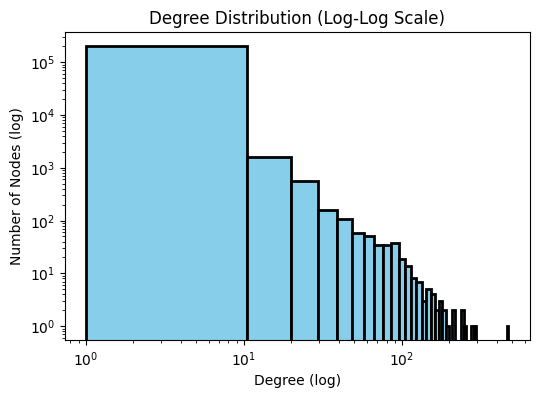

In [15]:
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

This graph shows that the network has a heavy-tailed degree distribution.

A few transactions interact with many others — potential hubs.

Most transactions interact with very few others.

The results are pretty common for financial-transaction graphs

In [16]:
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

Number of connected components: 49


In [17]:
# Giant component analysis (largest connected cluster)
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


**Node centrality measures**

### Degree centrality
- measures the number of direct connections a node has in a network. It is defined as the number of edges connected to a node.
A node with a high degree centrality is highly connected and may play a crucial role in the network by having direct interactions with many other nodes.

In [ ]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

# Subgraph of top nodes
top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)

# Get node colors based on centrality
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
cmap = plt.cm.cool

# Create scalar mappable for the colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


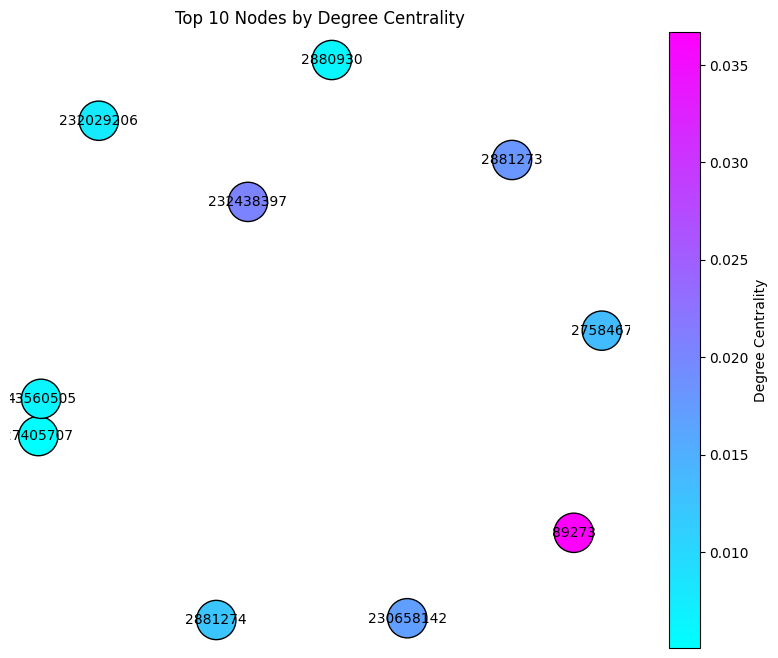

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color, cmap=cmap, node_size=800, edgecolors='black')
nx.draw_networkx_edges(subgraph, pos)
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.colorbar(sm, label='Degree Centrality', ax=plt.gca())
plt.title('Top 10 Nodes by Degree Centrality')
plt.axis('off')
plt.show()


### 2. Betweeness Centrality
- Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

- A node with high betweenness centrality has significant control over the flow of information or resources in the network because it connects different parts of the network. It often indicates a node that is critical for communication.

In [ ]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


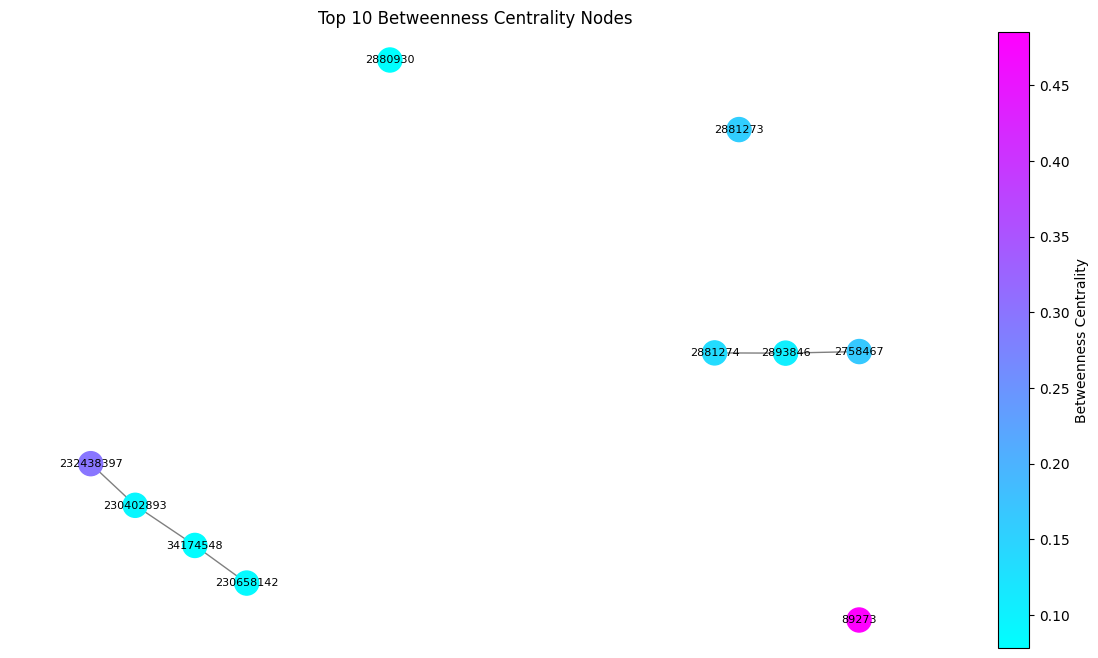

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(subgraph, pos,
                               node_color=node_color,
                               cmap=cmap,
                               node_size=300,
                               ax=ax)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Betweenness Centrality')

ax.set_title('Top 10 Betweenness Centrality Nodes')
ax.axis('off')
plt.show()

### 3. Closeness Centrality
- Closeness centrality measures how close a node is to all other nodes in the network. It is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network.
-  A node with high closeness centrality can quickly interact with all other nodes and can be an effective spreader of information or influence throughout the network.

In [ ]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool


Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


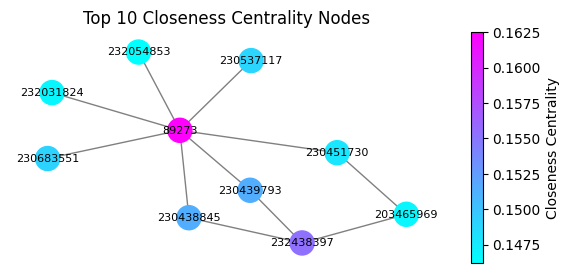

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(
    subgraph, pos,
    node_color=node_color,
    cmap=cmap,
    node_size=300,
    ax=ax
)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

# Create colorbar from scalar mappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Closeness Centrality')

ax.set_title('Top 10 Closeness Centrality Nodes')
ax.axis('off')
plt.show()

**Class-specific analysis**

In [ ]:
# Class-based subgraphs.
#illicit_nodes = classes_df[classes_df['class'] == 1]['txId']
#licit_nodes = classes_df[classes_df['class'] == 2]['txId']
illicit_nodes = classes_df[classes_df['class'] == 'illicit']['txId']
licit_nodes = classes_df[classes_df['class'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

Text(0.5, 1.0, 'Illicit Transactions Subgraph')

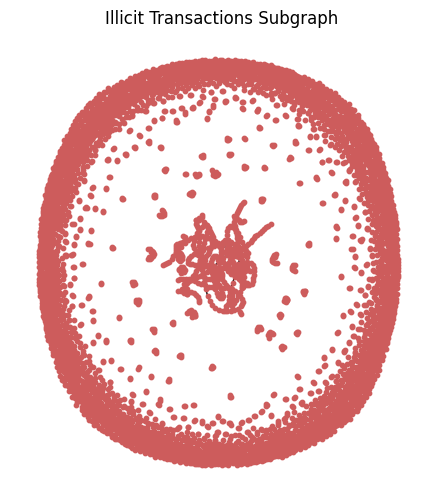

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')

In [ ]:
# plt.subplot(1, 2, 2)
# nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
# plt.title('Licit Transactions Subgraph')

# plt.show()

TODO:
- explore the 89273 node (show whether it is illicit, licit, unknown)
- merge features with classes
- sort tx_idx for classes and edges
- ML classify only with the transaction features and only with the aggregated ones -> compare the results ? if enough time
- For Node2Vec use (trans, agg and all features -> compare results)
- Use GIN with (trans, agg and all features -> compare results)
- Apply Deep Neural Decision Forest (suggested by prof paper) ? if enough time

In [ ]:
# class_values = sorted(classes["class"].unique())

In [ ]:
# tx_idx = {name: idx for idx, name in enumerate(sorted(classes["txId"].unique()))}

In [ ]:
# classes["txId"] = classes["txId"].apply(lambda name: tx_idx[name])

## DeepWalk

In [18]:
G_base = G_giant

In [19]:
all_nodes = list(G_base.nodes())
tx_idx = {tx: i for i, tx in enumerate(sorted(all_nodes))}
idx2tx = {i: tx for tx, i in tx_idx.items()}

In [20]:
# Build Integer Graph
def nx_from_edgelist(df_edges, mapping):
    df_int = df_edges.replace({'txId1': mapping, 'txId2': mapping})
    return nx.from_pandas_edgelist(df_int, 'txId1', 'txId2')

In [21]:
base_edges = edges[edges['txId1'].isin(G_base.nodes())]
base_edges = base_edges[base_edges['txId2'].isin(G_base.nodes())]

G_int = nx_from_edgelist(base_edges, tx_idx)

In [22]:
def random_walk(graph, start, walk_length, rng=None):
    walk = [start]
    if rng is None:
        rng = random.Random()

    for _ in range(walk_length - 1):
        cur = walk[-1]
        neighbours = list(graph[cur])
        if neighbours:
            walk.append(rng.choice(neighbours))
        else:
            break
    return walk

In [23]:
def _walk_worker(args):
    graph, node_batch, walk_len, walks_per_node = args
    rng = random.Random()
    walks = []
    for n in node_batch:
        for _ in range(walks_per_node):
            walks.append(random_walk(graph, n, walk_len, rng))
    return walks

In [24]:
def build_corpus(graph, walk_length=40, walks_per_node=10, workers=None):
    if workers is None:
        workers = mp.cpu_count()

    nodes = list(graph.nodes())
    np.random.shuffle(nodes)

    batches = np.array_split(nodes, workers)

    with mp.Pool(workers) as pool:
        results = pool.map(
            _walk_worker,
            [(graph, batch, walk_length, walks_per_node) for batch in batches]
        )

    return [walk for sub in results for walk in sub]

In [25]:
def train_word2vec(sentences, dim=128, window=10, epochs=5, neg=5, workers=mp.cpu_count()):
    model = Word2Vec(
        sentences=sentences,
        vector_size=dim,
        window=window,
        min_count=0,
        sg=1,
        hs=0,
        negative=neg,
        workers=workers,
        epochs=epochs,
        seed=42
    )
    return model

In [26]:
def save_embeddings(w2v_model, path_pt='deepwalk.pt', path_txt='deepwalk.txt'):
    vectors = torch.tensor(w2v_model.wv.vectors)          # (N, dim)
    torch.save(vectors, path_pt)

    with open(path_txt, 'w') as f:
        dim = vectors.shape[1]
        f.write(f"{vectors.shape[0]} {dim}\n")
        for node, vec in w2v_model.wv.key_to_index.items():
            vec_str = " ".join(map(str, w2v_model.wv[node]))
            f.write(f"{node} {vec_str}\n")

In [27]:
def run_deepwalk(graph, params):
    corpus = build_corpus(graph,
                          walk_length=params['walk_length'],
                          walks_per_node=params['walks_per_node'])
    w2v     = train_word2vec(corpus,
                             dim=params['dim'],
                             window=params['window'],
                             epochs=params['epochs'],
                             neg=params['neg'])
    save_embeddings(w2v,
                    path_pt=params['out_pt'],
                    path_txt=params['out_txt'])
    return w2v

In [28]:
params = dict(walk_length=40, walks_per_node=10,
              dim=128, window=10, epochs=5, neg=5,
              out_pt='elliptic_deepwalk.pt', out_txt='elliptic_deepwalk.txt')
run_deepwalk(G_int, params)

In [29]:
if __name__ == "__main__":
    default_pars = dict(
        walk_length=40,
        walks_per_node=10,
        dim=128,
        window=10,
        epochs=5,
        neg=5,
        out_pt='deepwalk_embeddings.pt',
        out_txt='deepwalk_embeddings.txt'
    )
    w2v_model = run_deepwalk(G_int, default_pars)
    print("Done! Embeddings saved to", default_pars['out_pt'])

Done! Embeddings saved to deepwalk_embeddings.pt


In [30]:
z = torch.load('elliptic_deepwalk.pt')  # (N, 128)

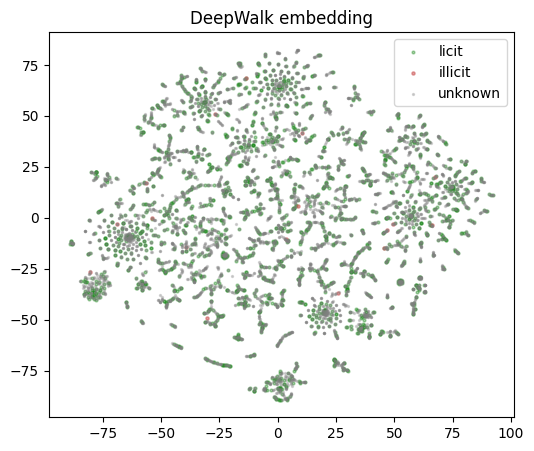

In [31]:
y = classes.set_index('txId')['class'].map({'illicit': 1, 'licit': 0, 'unknown': -1})

all_tx_ids_in_embedding_order = list(tx_idx.keys())
y = y[y.index.isin(all_tx_ids_in_embedding_order)]
y = y.reindex(all_tx_ids_in_embedding_order)
y = torch.tensor(y.values)

tsne = TSNE(n_components=2, perplexity=40, init='random', random_state=42)
xy = tsne.fit_transform(z.numpy())

plt.figure(figsize=(6, 5))
plt.scatter(xy[y == 0, 0], xy[y == 0, 1], s=4, c='forestgreen', label='licit', alpha=.4)
plt.scatter(xy[y == 1, 0], xy[y == 1, 1], s=5, c='indianred', label='illicit', alpha=.6)
plt.scatter(xy[y == -1, 0], xy[y == -1, 1], s=2, c='gray', label='unknown', alpha=0.3)

plt.legend()
plt.title("DeepWalk embedding")
plt.show()

## GGGRAPHSAGEEE

In [32]:
# convert networkx -> PyG
pyg_data = from_networkx(G_int)

In [33]:
# prepare feature matrix X in the same tx-order as tx_idx
feat_cols = trans_features + agg_features
ordered_txs = [idx2tx[i] for i in range(len(idx2tx))]
X = features.set_index('txId').loc[ordered_txs, feat_cols].values
pyg_data.x = torch.tensor(X, dtype=torch.float)

In [34]:
# prepare labels (licit=0, illicit=1), and ignore unknown (-1)
y_series = classes.set_index('txId')['class'].map({'licit':0, 'illicit':1, 'unknown':-1})
y = torch.tensor(y_series.loc[ordered_txs].values, dtype=torch.long)
pyg_data.y = y

In [35]:
# create train/val/test masks (80/10/10 random split, only on known labels)
num_nodes = y.size(0)
mask_known = (y >= 0)
known_indices = mask_known.nonzero(as_tuple=False).view(-1)
perm = known_indices[torch.randperm(known_indices.size(0))]
n_train = int(0.8 * perm.size(0))
n_val   = int(0.1 * perm.size(0))

train_idx = perm[:n_train]
val_idx   = perm[n_train:n_train+n_val]
test_idx  = perm[n_train+n_val:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[ val_idx]   = True
test_mask[test_idx]  = True

pyg_data.train_mask = train_mask
pyg_data.val_mask   = val_mask
pyg_data.test_mask  = test_mask

In [36]:
# 2) Define the GraphSAGE model
# --------------------------------------------------
class GraphSAGENet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=2, dropout=0.5):
        super().__init__()
        convs = []
        # input layer
        convs.append(SAGEConv(in_channels, hidden_channels))
        # any intermediate layers
        for _ in range(num_layers - 2):
            convs.append(SAGEConv(hidden_channels, hidden_channels))
        # output layer
        convs.append(SAGEConv(hidden_channels, out_channels))
        self.convs = nn.ModuleList(convs)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

# instantiate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGENet(
    in_channels=pyg_data.x.size(1),
    hidden_channels=128,
    out_channels=2,
    num_layers=2,
    dropout=0.5
).to(device)
pyg_data = pyg_data.to(device)

In [37]:
# 3) Set up neighbor samplers for mini-batch training
# --------------------------------------------------
train_loader = NeighborLoader(
    pyg_data,
    input_nodes= pyg_data.train_mask,
    num_neighbors=[15, 10],
    batch_size=64,
    shuffle=True
)
val_loader = NeighborLoader(
    pyg_data,
    input_nodes= pyg_data.val_mask,
    num_neighbors=[15, 10],
    batch_size=64
)
test_loader = NeighborLoader(
    pyg_data,
    input_nodes= pyg_data.test_mask,
    num_neighbors=[15, 10],
    batch_size=64
)

In [38]:
# 4) Training & evaluation routines
# --------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [43]:
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # only compute loss on the root nodes of this batch
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size
    return total_loss / pyg_data.train_mask.sum().item()

In [44]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    ys, preds = [], []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        y_true = batch.y[:batch.batch_size].cpu()
        y_pred = out[:batch.batch_size].argmax(dim=1).cpu()
        ys.append(y_true)
        preds.append(y_pred)
    y_true = torch.cat(ys)
    y_pred = torch.cat(preds)
    acc = (y_true == y_pred).float().mean().item()
    return acc, y_true, y_pred

In [45]:
# 5) Run training loop
# --------------------------------------------------
epochs = 20
for epoch in range(1, epochs + 1):
    loss = train_epoch()
    val_acc, _, _ = evaluate(val_loader)
    print(f"Epoch {epoch:02d}  Train Loss: {loss:.4f}  Val Acc: {val_acc:.4f}")

Epoch 01  Train Loss: 0.0369  Val Acc: 0.9907
Epoch 02  Train Loss: 0.0232  Val Acc: 0.9907
Epoch 03  Train Loss: 0.0237  Val Acc: 0.9907
Epoch 04  Train Loss: 0.0247  Val Acc: 0.9860
Epoch 05  Train Loss: 0.0182  Val Acc: 0.9907
Epoch 06  Train Loss: 0.0299  Val Acc: 0.9860
Epoch 07  Train Loss: 0.0156  Val Acc: 0.9907
Epoch 08  Train Loss: 0.0154  Val Acc: 0.9907
Epoch 09  Train Loss: 0.0168  Val Acc: 0.9860
Epoch 10  Train Loss: 0.0103  Val Acc: 0.9907
Epoch 11  Train Loss: 0.0179  Val Acc: 0.9907
Epoch 12  Train Loss: 0.0110  Val Acc: 0.9907
Epoch 13  Train Loss: 0.0162  Val Acc: 0.9907
Epoch 14  Train Loss: 0.0122  Val Acc: 0.9953
Epoch 15  Train Loss: 0.0146  Val Acc: 0.9907
Epoch 16  Train Loss: 0.0113  Val Acc: 0.9907
Epoch 17  Train Loss: 0.0099  Val Acc: 0.9907
Epoch 18  Train Loss: 0.0121  Val Acc: 0.9907
Epoch 19  Train Loss: 0.0129  Val Acc: 0.9907
Epoch 20  Train Loss: 0.0247  Val Acc: 0.9860


In [46]:
# final test performance
test_acc, y_true_test, y_pred_test = evaluate(test_loader)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(classification_report(y_true_test, y_pred_test, target_names=['licit','illicit']))


Test Accuracy: 0.9907
              precision    recall  f1-score   support

       licit       0.99      1.00      1.00       214
     illicit       0.00      0.00      0.00         2

    accuracy                           0.99       216
   macro avg       0.50      0.50      0.50       216
weighted avg       0.98      0.99      0.99       216



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
